In [1]:
import numpy as np
from typing import Iterable
import matplotlib.pyplot as plt

from pyquac_light.datatools import Spectroscopy, busy_sleep


class RandomSpectroscopy(Spectroscopy):
    """
    Simulated Two-Tone Spectroscopy demo:
      • Full raster scan (all x's or a chosen subset).
      • Ridge fit (optionally on a subset of x's).
      • Corridor scan (all x's or a chosen subset).
    """

    def run_full_scan(self,
                      sleep: float = 0.001,
                      x_subset: Iterable[float] | None = None) -> None:
        """
        Measure every (x,y) once, or only for x in `x_subset`.
        Off-grid x's in `x_subset` are snapped to the nearest grid point.
        """
        xs, ys = self.next_unmeasured_points(x_subset=x_subset)
        for x, y in zip(xs, ys):
            z = np.random.random()
            self.write(x, y, z)
            busy_sleep(sleep)

    def run_corridor_scan(self,
                          ridge: np.poly1d,
                          width_frac: float = 0.2,
                          sleep: float = 0.001,
                          x_subset: Iterable[float] | None = None) -> None:
        """
        Measure only points within ±width_frac corridor around `ridge`,
        and only for x in `x_subset` if provided.
        """
        mask = self.corridor_mask(ridge, width_frac=width_frac)
        xs, ys = self.next_unmeasured_points(mask=mask,
                                              x_subset=x_subset)
        for x, y in zip(xs, ys):
            z = np.random.random()
            self.write(x, y, z)
            busy_sleep(sleep)

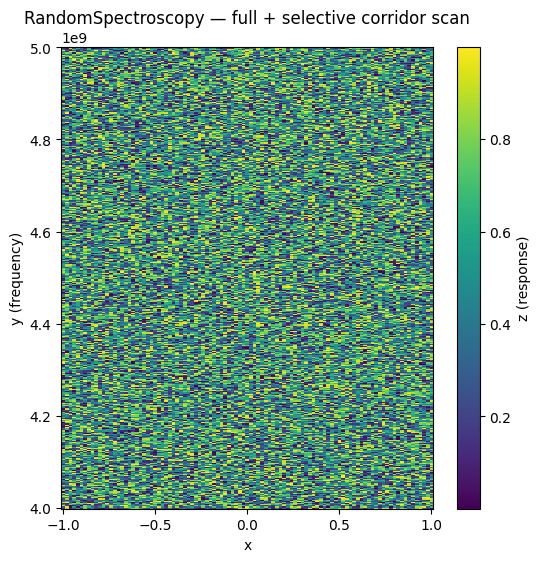

In [2]:
# 1) Define the uniform grids once
x_arr = np.linspace(-1.0, 1.0, 101)
y_arr = np.linspace(4e9, 5e9, 401)

spec = RandomSpectroscopy(x_arr=x_arr, y_arr=y_arr)

# 2) Full scan over *all* x
spec.run_full_scan(sleep=1e-6)

# 5) Plot the accumulated heatmap
plt.figure(figsize=(6,6))
X, Y = np.meshgrid(spec.x_arr, spec.y_arr)
plt.pcolormesh(X, Y, spec.z_matrix, shading="auto")
plt.xlabel("x")
plt.ylabel("y (frequency)")
plt.title("RandomSpectroscopy — full + selective corridor scan")
plt.colorbar(label="z (response)")
plt.show()

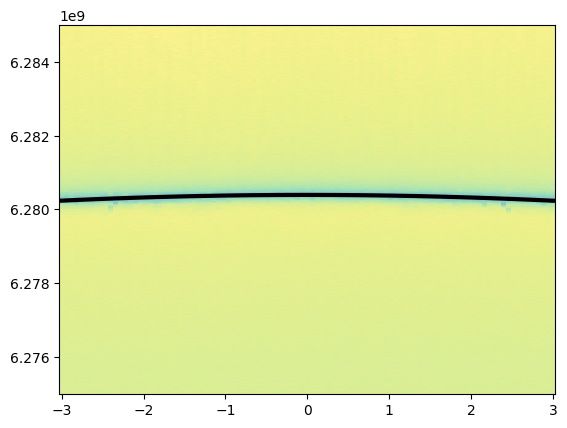

In [3]:
spec = RandomSpectroscopy.load_csv("example_data.csv")
plt.pcolormesh(spec.x_arr, spec.y_arr, spec.z_matrix, shading="auto", alpha=0.5)

ridge = spec.fit_ridge(deg=2, x_subset=None)
plt.plot(spec.x_arr, ridge(spec.x_arr), c="black", lw=3)

In [4]:
idxs = np.arange(len((spec.x_arr)))
idx_remain = np.random.choice(idxs, 5)
mask = ~np.isin(idxs, idx_remain)
x_to_drop = spec.x_arr[mask]

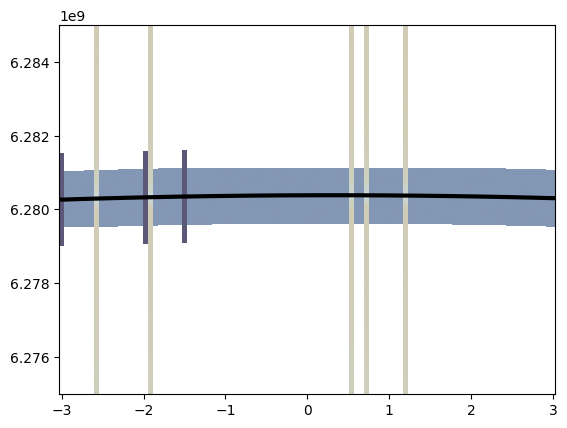

In [5]:
spec.drop(x=x_to_drop)
plt.pcolormesh(spec.x_arr, spec.y_arr, spec.z_matrix, shading="auto", alpha=0.5)

ridge = spec.fit_ridge(deg=2)
plt.plot(spec.x_arr, ridge(spec.x_arr), c="black", lw=3)

# Corridor scan, but *only* at x = [-3.48, -2.0, -1.51] (snapped to grid)
spec.run_corridor_scan(ridge,
                        width_frac=0.25,
                        sleep=1e-6,
                        x_subset=[-3.48, -2.0, -1.51])

plt.pcolormesh(spec.x_arr, spec.y_arr, spec.z_matrix, shading="auto", alpha=0.5, cmap="Reds")

# Full coridor scan
spec.run_corridor_scan(ridge,
                        width_frac=0.15,
                        sleep=1e-6)
plt.pcolormesh(spec.x_arr, spec.y_arr, spec.z_matrix, shading="auto", alpha=0.5, cmap="Blues")

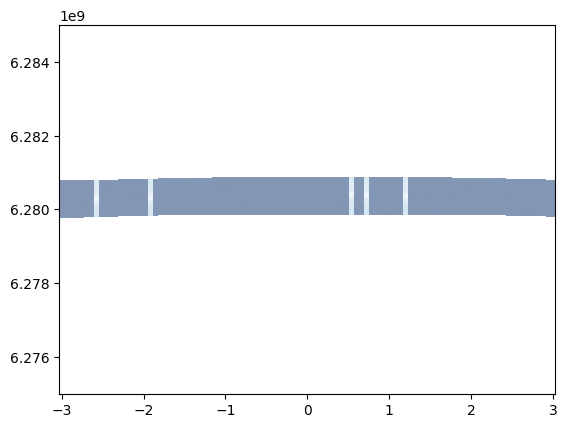

In [6]:
spec.clean_up(ridge, width_frac=0.1)
plt.pcolormesh(spec.x_arr, spec.y_arr, spec.z_matrix, shading="auto", alpha=0.5, cmap="Blues")